In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from activ import load_data
from PyUoI.UoINMF import UoINMF
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from activ.data_normalization import data_normalization
from scipy.spatial.distance import pdist
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import CCA
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
nmfdata = load_data(uoinmf=True)

In [4]:
bm_factors = nmfdata.biomarkers
oc_factors = nmfdata.outcomes
bm_factors.shape
oc_factors.shape

(247, 6)

In [5]:
cca = CCA(n_components=1)
cca.fit(bm_factors, oc_factors)
X_c, Y_c = cca.transform(bm_factors, oc_factors)

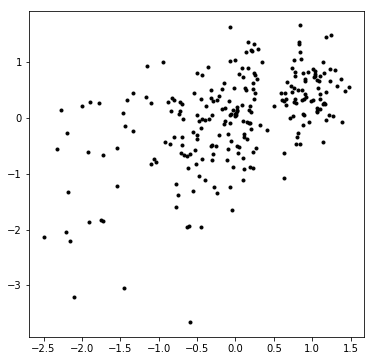

In [111]:
plt.figure(figsize=(6,6))
plt.plot(cca.x_scores_, cca.y_scores_, '.', color='black')

In [7]:
# R2
r2 = r2_score(X_c, Y_c)
r2


0.09676005691361689

In [8]:
X_c = np.squeeze(X_c)
Y_c = np.squeeze(Y_c)
X_c.shape

(247,)

In [9]:
slope, intercept = np.polyfit(X_c, Y_c, 1)
abline_values = [slope * i + intercept for i in X_c]


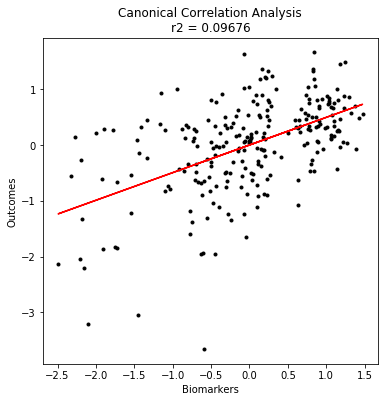

In [10]:
plt.figure(figsize=(6,6))
plt.xlabel('Biomarkers')
plt.ylabel('Outcomes')
plt.title('Canonical Correlation Analysis\nr2 = 0.09676')
plt.plot(X_c, Y_c, '.', color='black')
plt.plot(X_c, abline_values, color='red')
plt.savefig('/Users/ahyeon/Desktop/activ misc/cca.pdf')

2 0.661454272341413
3 0.4993532788910929
4 0.46544196678801336
5 0.4263312654684658
6 0.5098092634961985
7 0.4046365501070646
8 0.7784923407410613
9 0.45326793209695376
10 0.6458209508636785
11 0.6588566190294807
12 0.6726471461770116
13 0.6211637274140015
14 0.7214955250894864
15 0.587362920121028


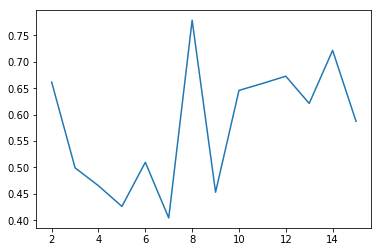

In [123]:

accs = []
for d in depth:
    rf = RandomForestRegressor(max_depth=d)
    X_train, X_test, y_train, y_test = train_test_split(cca.x_scores_, cca.y_scores_[:,0], test_size=0.2)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = metrics.mean_squared_error(y_test, y_pred)
    accs.append(acc)
    print(d, acc)
plt.plot(depth, accs)

In [100]:
depth = np.arange(2,16,1)
for d in depth:
    X_train, X_test, y_train, y_test = train_test_split(cca.x_scores_, cca.y_scores_, test_size=0.2)
    rf = RandomForestRegressor(max_depth=d).fit(X_train, y_train[:,0])
    r2 = r2_score(y_test, rf.predict(X_test))
    print(r2)

0.2735942937765896
0.19350905366310822
-0.10704251220480798
-0.3248408941972458
0.0752231531454054
-0.5368431637406259
0.16011100779729637
-1.1878509722284973
0.1836813113195398
-0.07027472417586456
-0.0004731207287642647
0.19019985442124732
0.08325088385926915
0.055130838930255166


In [6]:
cca.x_scores_.shape

(247, 1)

2
-0.01206350851517537
3
-0.09486036831734175
4
-0.14985300030495602
5
-0.20879956042553754
6
-0.1863377175496723
7
-0.3325466858034627
8
-0.3070200851930364
9
-0.4009705586084956
10
-0.4105050713374257
11
-0.3838304506157212
12
-0.3734571477974974
13
-0.41072953263254586
14
-0.4598341472228357
15
-0.47643033620036934
16
-0.4380972167119953
17
-0.49391394586820014
18
-0.38602014487062924
19
-0.42150309194483687
20
-0.3900625395492925
21
-0.48260638930293603
22
-0.34298902415975563
23
-0.4936707012491671
24
-0.4222300862450342
25
-0.4504693976925278
26
-0.3979936673680655
27
-0.46364739742063266
28
-0.4437435230861384
29
-0.42867281617952935


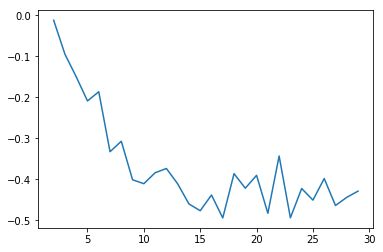

In [135]:
depth = np.arange(2,30,1)
accs = list()
for d in depth:
    print(d)
    rf = RandomForestRegressor(max_depth=d)
    rf.fit(cca.x_scores_, cca.y_scores_[:,0])
    acc = cross_val_score(rf, cca.x_scores_, cca.y_scores_[:,0], cv=5, scoring = metrics.make_scorer(metrics.r2_score))
    mean_acc = np.mean(acc)
    accs.append(mean_acc)
    print(mean_acc)
plt.plot(depth, accs)

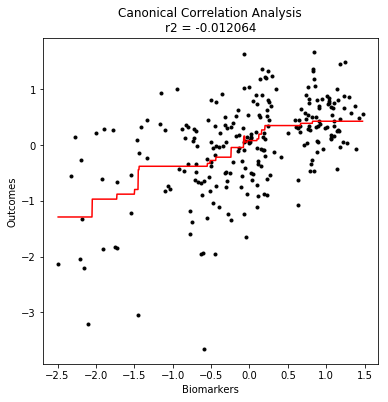

In [136]:
rf = RandomForestRegressor(max_depth=2).fit(cca.x_scores_, cca.y_scores_[:,0])
r2 = r2_score(cca.y_scores_, rf.predict(cca.x_scores_))
r2_crossval = -0.01206350851517537
tmp = cca.x_scores_[:,0]
xfit = np.linspace(min(tmp), max(tmp), 1000).reshape((1000,1))
yfit = rf.predict(xfit)

plt.figure(figsize=(6,6))
plt.xlabel('Biomarkers')
plt.ylabel('Outcomes')
plt.title('Canonical Correlation Analysis\nr2 = %0.6f' % r2_crossval)
plt.plot(X_c, Y_c, '.', color='black')
plt.plot(xfit, yfit, color='red')
plt.savefig('/Users/ahyeon/Desktop/activ misc/cca.pdf')
